In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC

In [37]:
df = pd.read_csv('../data/raw/student-combine.csv')

In [38]:
df.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000
mean,16.726054,2.603448,2.387931,1.522989,1.970307,0.264368,3.935824,3.201149,3.156130,1.494253,2.284483,3.543103,4.434866,11.213602,11.246169,11.341954
std,1.239975,1.124907,1.099938,0.731727,0.834353,0.656142,0.933401,1.031507,1.152575,0.911714,1.285105,1.424703,6.210017,2.983394,3.285071,3.864796
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,9.000000,9.000000,10.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


## Question Formualation & Data Analysis

### Question: Liệu age ảnh hưởng đến điểm G3 khác nhau giữa nam và nữ không?

### Motivation & Benefits:
**Why is this question worth investigating?**
- Tuổi tác có thể liên quan đến mức độ trưởng thành, khả năng học tập và áp lực học tập.

**What benefits or insights would answering this question provide?**
- Giúp giáo viên và nhà trường xác định nhóm học sinh cần hỗ trợ đặc biệt (ví dụ, nam học sinh lớn tuổi có thể gặp khó khăn hơn)
- Cho phép lập kế hoạch giáo dục cá nhân hóa, mentoring hoặc hướng dẫn thêm cho nhóm học sinh rủi ro cao

**Who would care about the answer?**
- Giáo viên, cố vấn học tập, ban giám hiệu 
- Phụ huynh quan tâm đến tiến độ học tập của con.

**What real-world problem or decision does this inform?**
- Quyết định phân bổ nguồn lực hỗ trợ học tập: dạy kèm, mentoring, tư vấn nhóm.
- Đưa ra chính sách giảng dạy phù hợp với từng nhóm tuổi và giới tính.

### A. Preprocessing 

- Chuyển đổi kiểu dữ liệu sex sang category
- Lọc dữ liệu theo tuổi hợp lý age
- Kiểm tra thống kê mô tả cơ bản age, sex, G3
- Tổng hợp điểm trung bình G3 theo tuổi và giới tính

In [ ]:
df['sex'] = df['sex'].astype('category')
df = df[(df['age'] >= 15) & (df['age'] <= 22)]
print(df[['age','sex','G3']].describe())

               age           G3
count  1044.000000  1044.000000
mean     16.726054    11.341954
std       1.239975     3.864796
min      15.000000     0.000000
25%      16.000000    10.000000
50%      17.000000    11.000000
75%      18.000000    14.000000
max      22.000000    20.000000


In [40]:
age_sex_summary = df.groupby(['age','sex'])['G3'].mean().reset_index()
print(age_sex_summary)

    age sex         G3
0    15   F  11.021053
1    15   M  12.444444
2    16   F  11.779874
3    16   M  11.450820
4    17   F  12.070175
5    17   M  10.745283
6    18   F  11.125984
7    18   M  10.715789
8    19   F   8.939394
9    19   M   9.000000
10   20   F  12.400000
11   20   M  13.000000
12   21   F  12.000000
13   21   M   8.500000
14   22   F        NaN
15   22   M   6.500000


C:\Users\manhh\AppData\Local\Temp\ipykernel_15056\3235330407.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_sex_summary = df.groupby(['age','sex'])['G3'].mean().reset_index()


### B. Analysis
**Scatter Plot:**
- Mục đích: 
    - Hiển thị các điểm dữ liệu riêng lẻ (G3 theo age), phân biệt theo giới tính
    - Cho phép trực quan hóa sự phân tán, điểm outlier, và mối quan hệ thô giữa tuổi và điểm số cho từng nhóm nam/nữ

**Line Plot:**
- Mục đích: 
    - Vẽ trend trung bình điểm G3 theo từng tuổi, tách theo giới tính
    - Giúp thấy xu hướng tổng thể và sự khác biệt giữa nam và nữ theo tuổi, thay vì chỉ nhìn từng điểm rời rạc

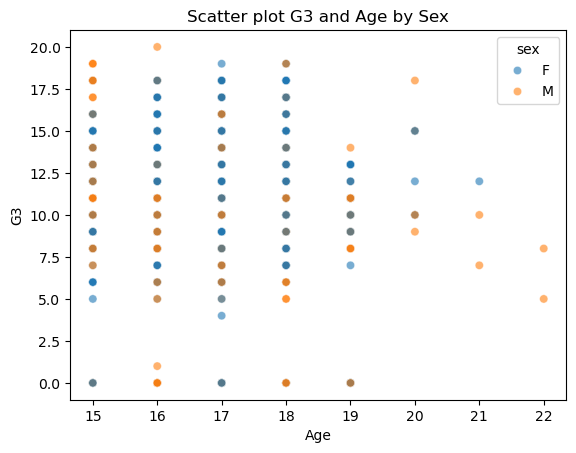

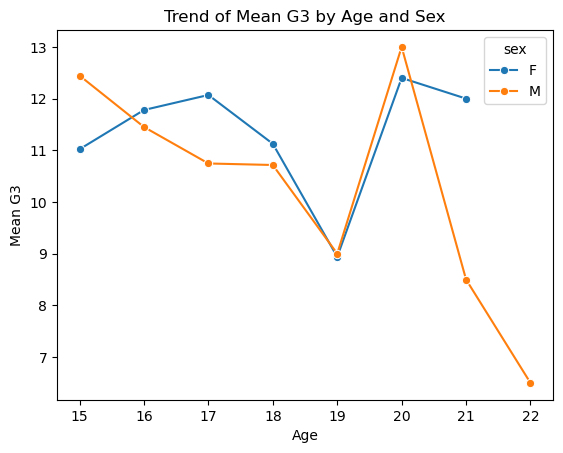

In [41]:
sns.scatterplot(data=df, x='age', y='G3', hue='sex', alpha=0.6)
plt.title('Scatter plot G3 and Age by Sex')
plt.xlabel('Age')
plt.ylabel('G3')
plt.show()

sns.lineplot(data=age_sex_summary, x='age', y='G3', hue='sex', marker='o')
plt.title('Trend of Mean G3 by Age and Sex')
plt.xlabel('Age')
plt.ylabel('Mean G3')
plt.show()

**Nhận xét:**
- Nam học sinh tuổi 21–22 có G3 giảm mạnh 
- Nữ có trend ổn định hơn, điểm trung bình ít biến động

**Ý nghĩa:**
- Học sinh nam lớn tuổi hơn (21–22) có nguy cơ rớt môn cao hơn, cần sự hỗ trợ học tập và mentoring đặc biệt
- Nhà trường có thể lập kế hoạch tư vấn, dạy kèm hoặc can thiệp sớm cho nhóm nam lớn tuổi để giảm tỷ lệ rớt môn

**Hạn chế**
- Số học sinh ở các tuổi lớn (21–22) có thể ít, dẫn đến điểm trung bình dao động mạnh.
- Dữ liệu chỉ tính trung bình, không phản ánh phân phối từng học sinh.
- Phân tích chưa kiểm định thống kê inferential (ví dụ t-test hay ANOVA) để xác nhận sự khác biệt có ý nghĩa

### Question: Dự đoán học sinh có nguy cơ rớt môn dựa trên các yếu tố hành vi  (romantic, goout, Dalc, Walc, health, freetime) và G1,G2

**Why is this question worth investigating?**
- Học sinh rớt môn là vấn đề phổ biến, ảnh hưởng đến tiến độ học tập và tâm lý học sinh.
- Việc dự đoán sớm giúp can thiệp kịp thời, trước khi kết quả học tập trở nên xấu đi

**What benefits or insights would answering this question provide?**
- Xác định các yếu tố hành vi ảnh hưởng mạnh đến nguy cơ rớt môn.
- Hỗ trợ thiết kế các chương trình hỗ trợ học tập, tư vấn tâm lý, quản lý thời gian và thói quen sinh hoạt học sinh.

**Who would care about the answer?**
- Giáo viên, cố vấn học tập, ban giám hiệu

**What real-world problem or decision does this inform?**
- Quyết định ai cần được tư vấn, mentoring hoặc hỗ trợ thêm.
- Phát triển hệ thống cảnh báo sớm để giảm tỷ lệ học sinh rớt môn.

### A. Preprocessing

- Chọn các biến liên quan
- Mã hóa biến categorical romantic: 0 - không có romantic, 1 - có romantic
- Tạo nhãn dự đoán
- Chia dữ liệu train/test
- Scale dữ liệu

In [42]:
risk_of_fail = df[['romantic', 'goout', 'Dalc', 'Walc', 'health', 'freetime','G1','G2']]
risk_of_fail['romantic'] = risk_of_fail['romantic'].map({'yes': 1, 'no': 0})
label_risk = (df['G3'] < 10).astype(int)

C:\Users\manhh\AppData\Local\Temp\ipykernel_15056\2953468566.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  risk_of_fail['romantic'] = risk_of_fail['romantic'].map({'yes': 1, 'no': 0})


In [43]:
label_risk.value_counts()

G3
0    814
1    230
Name: count, dtype: int64

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    risk_of_fail, 
    label_risk, 
    test_size=0.2, 
    random_state=42,
    stratify = label_risk
)

In [67]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### B. Analysis
**Logistic Regression:**
- Chọn Logistic Regression vì đây là bài toán classification nhị phân
- Mô hình đơn giản, dễ giải thích, có thể cung cấp xác suất dự đoán.
- Thích hợp làm baseline model trước khi thử các model phức tạp hơn.

**Support Vector Classifier (SVC):**
- Sử dụng kernel RBF để model có thể học các ranh giới phân lớp không tuyến tính.
- SVC thường có hiệu suất tốt với dữ liệu có số chiều vừa phải và có thể bắt được pattern phức tạp hơn Logistic Regression.

**Evaluation Metrics:**
- Accuracy: Đánh giá tổng thể mức độ dự đoán đúng.
- Confusion Matrix: Quan sát số lượng học sinh dự đoán đúng/sai theo lớp Low Risk / High Risk.
- Classification Report: Bao gồm precision, recall, f1-score → giúp hiểu rõ hiệu suất từng lớp, quan trọng khi dữ liệu mất cân bằng.

**Workflow Logic:**
- Dữ liệu đã được preprocessing và scale (StandardScaler) để đảm bảo mô hình hoạt động ổn định.
- Train model trên X_train_scaled và test trên X_test_scaled.
- Đánh giá kết quả bằng accuracy, confusion matrix và classification report.
- So sánh hiệu quả giữa Logistic Regression (linear, dễ giải thích) và SVC (non-linear, mạnh hơn).

In [68]:
model  = LogisticRegression(
    solver = 'sag',
    max_iter=100,
    random_state=42
)

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_train_scaled)
print("Train accuracy:", accuracy_score(y_train, y_pred))
y_pred_test = model.predict(X_test_scaled)
print("Test accuracy:", accuracy_score(y_test, y_pred_test))

Train accuracy: 0.9233532934131736
Test accuracy: 0.9186602870813397


Text(0.5, 427.9555555555555, 'Predicted label')

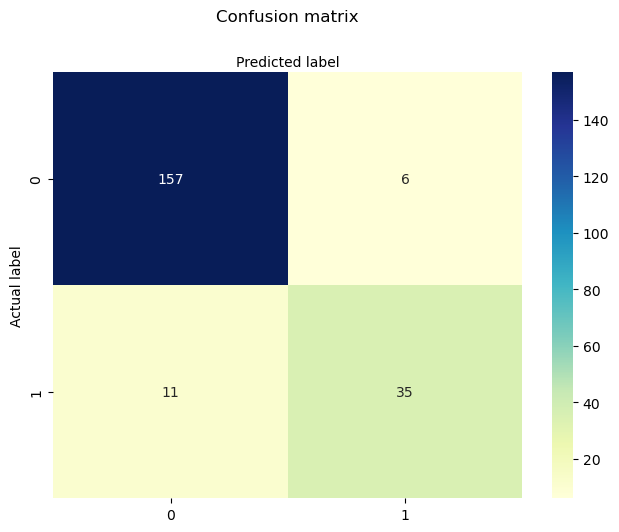

In [47]:
cnf_matrix = confusion_matrix(y_test, y_pred_test)
class_names=[0,1] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [48]:
print(classification_report(y_test, y_pred_test, target_names=['Low Risk', 'High Risk']))

              precision    recall  f1-score   support

    Low Risk       0.93      0.96      0.95       163
   High Risk       0.85      0.76      0.80        46

    accuracy                           0.92       209
   macro avg       0.89      0.86      0.88       209
weighted avg       0.92      0.92      0.92       209



In [ ]:
model_svc = SVC(
    kernel='rbf',    
    random_state=42
)
model_svc.fit(X_train_scaled, y_train)
# Train
y_pred_train = model_svc.predict(X_train_scaled)
print("Train accuracy:", accuracy_score(y_train, y_pred_train))

# Test
y_pred_test = model_svc.predict(X_test_scaled)
print("Test accuracy:", accuracy_score(y_test, y_pred_test))


Train accuracy: 0.9293413173652695
Test accuracy: 0.9043062200956937


Text(0.5, 427.9555555555555, 'Predicted label')

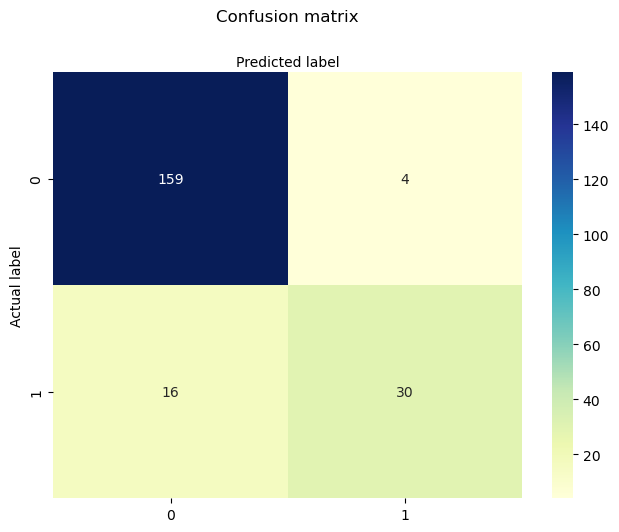

In [55]:
cnf_matrix = confusion_matrix(y_test, y_pred_test)
class_names=[0,1] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [56]:
print(classification_report(y_test, y_pred_test, target_names=['Low Risk', 'High Risk']))

              precision    recall  f1-score   support

    Low Risk       0.91      0.98      0.94       163
   High Risk       0.88      0.65      0.75        46

    accuracy                           0.90       209
   macro avg       0.90      0.81      0.85       209
weighted avg       0.90      0.90      0.90       209

